In [8]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import time
import re
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
from sentence_transformers import SentenceTransformer, util
from nltk.tokenize import sent_tokenize
import torch
import nltk

### 통합데이터 read

In [11]:
df = pd.read_csv(r'C:\Users\user\boyu571_github\01_Kakaobank_SKKU_Research_23\naver_news_data.csv')
df

,date,time,title,content,press,link
0,2017-01-01,2017-01-01 07:00:00,한국 금융산업 위기… ‘우버 모멘트’ 를 넘어라,\n\n\n\n\n© News1저금리·저성장 전통 금융산업 위기4차 산업혁명...세...,뉴스1,https://n.news.naver.com/mnews/article/421/000...
1,2017-01-01,2017-01-01 15:15:04,"英 파운드, 2016년 최악의 통화 ···'디지털통화' 비트코인 최고의 수익자산...",\n【뉴욕=정지원 특파원】 영국의 파운드가 2106년 최악의 통화로 기록됐다.\n ...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...
2,2017-01-01,2017-01-01 16:03:04,"[신년기획]블록체인, 금융권 넘어 IT기업도 관심",\n\t\t\t“블록체인은 인터넷 이후 나온 가장 혁신적이며 파괴적인 기술이다.”블...,39면 1단,https://n.news.naver.com/mnews/article/030/000...
3,2017-01-01,NaN,[2017 신년특집] 세계 금융의 대변화-화폐없는 시대가 온다 디지털 가상화폐 ...,NaN,울산매일신문,http://www.iusm.co.kr
4,2017-01-01,NaN,"[아시아 밀레니얼이 미래다] 게으른 나르시스트, 신 경제 창조하는 이 시대의...",NaN,아시아투데이,http://www.asiatoday.co.kr
...,...,...,...,...,...,...
869329,2023-08-30,2023-08-30 06:30:00,갈수록 줄어드는 스테이블코인 유통량…가상자산 가격도 횡보,\n스테이블코인 유통량 증가하면 가상자산 가격도 올라이변 없었던 잭슨홀 미팅 호재에...,6면 1단,https://n.news.naver.com/mnews/article/277/000...
869330,2023-08-30,2023-08-30 06:54:01,"[이충재의 인사이트] 김남국 징계 계기, 국회의원 '정직 6개월' 두자",\n'30일내 출석정지'와 '제명' 간 차이 커 실효성 논란...윤리특위 징계 유명...,오마이뉴스언론사 선정,https://n.news.naver.com/mnews/article/047/000...
869331,2023-08-30,2023-08-30 06:11:00,오늘 김남국 제명안 표결···'숙고의 시간' 거친 민주당 선택은,\n[the300]\n\n\n\n(서울=뉴스1) 임세영 기자 = 김남국 무소속 의원...,머니투데이,https://n.news.naver.com/mnews/article/008/000...
869332,2023-08-30,2023-08-30 06:20:57,국회 윤리특위 오늘 김남국 징계 수위 결정,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n[뉴스투데이]국회 윤리특별위원...,MBC언론사 선정,https://n.news.naver.com/mnews/article/214/000...


In [13]:
df['title'] = df['title'].str.replace('\n', '').str.replace('\t', '')
df['content'] = df['content'].str.replace('\n', '').str.replace('\t', '')
df['title'] = df['title'].str.replace('\r', '')
df['content'] = df['content'].str.replace('\r', '')

In [14]:
# `title`이 동일한 경우 중복 행 삭제
df = df.drop_duplicates(subset='title')

# `content`가 동일한 경우 중복 행 삭제
df = df.drop_duplicates(subset='content')
df

,date,time,title,content,press,link
0,2017-01-01,2017-01-01 07:00:00,한국 금융산업 위기… ‘우버 모멘트’ 를 넘어라,© News1저금리·저성장 전통 금융산업 위기4차 산업혁명...세계는 핀테크 혁명 ...,뉴스1,https://n.news.naver.com/mnews/article/421/000...
1,2017-01-01,2017-01-01 15:15:04,"英 파운드, 2016년 최악의 통화 ···'디지털통화' 비트코인 최고의 수익자산...",【뉴욕=정지원 특파원】 영국의 파운드가 2106년 최악의 통화로 기록됐다. 파운드는...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...
2,2017-01-01,2017-01-01 16:03:04,"[신년기획]블록체인, 금융권 넘어 IT기업도 관심",“블록체인은 인터넷 이후 나온 가장 혁신적이며 파괴적인 기술이다.”블록체인을 바라보...,39면 1단,https://n.news.naver.com/mnews/article/030/000...
3,2017-01-01,NaN,[2017 신년특집] 세계 금융의 대변화-화폐없는 시대가 온다 디지털 가상화폐 ...,NaN,울산매일신문,http://www.iusm.co.kr
5,2017-01-01,2017-01-01 12:03:13,[2017 국제 핫이슈]블록체인 기술 확산,블록체인은 `제2의 인터넷` `넥스트 인터넷`으로 불린다. 새해에는 해킹이 어렵고 ...,전자신문,https://n.news.naver.com/mnews/article/030/000...
...,...,...,...,...,...,...
869327,2023-08-30,2023-08-30 06:43:01,"美법원, SEC에 비트코인 현물ETF 반려 결정 재고하라고 지시…비트코인 가격 ...",[로이터][헤럴드경제=김우영 기자] 미 연방법원이 비트코인 현물 상장지수펀드(ETF...,헤럴드경제,https://n.news.naver.com/mnews/article/016/000...
869329,2023-08-30,2023-08-30 06:30:00,갈수록 줄어드는 스테이블코인 유통량…가상자산 가격도 횡보,스테이블코인 유통량 증가하면 가상자산 가격도 올라이변 없었던 잭슨홀 미팅 호재에도 ...,6면 1단,https://n.news.naver.com/mnews/article/277/000...
869330,2023-08-30,2023-08-30 06:54:01,"[이충재의 인사이트] 김남국 징계 계기, 국회의원 '정직 6개월' 두자",'30일내 출석정지'와 '제명' 간 차이 커 실효성 논란...윤리특위 징계 유명무실...,오마이뉴스언론사 선정,https://n.news.naver.com/mnews/article/047/000...
869331,2023-08-30,2023-08-30 06:11:00,오늘 김남국 제명안 표결···'숙고의 시간' 거친 민주당 선택은,[the300](서울=뉴스1) 임세영 기자 = 김남국 무소속 의원이 24일 오후 서...,머니투데이,https://n.news.naver.com/mnews/article/008/000...


In [15]:
# 'content' 열이 비어있지 않은 행만 필터링
non_empty_content_datewise = df[df['content'].notnull()]


In [16]:
filtered_df = non_empty_content_datewise[
    ~non_empty_content_datewise['content'].str.contains('라이온봇|화폐에 대한 모든 것!', na=False)
]
removed_df = non_empty_content_datewise[
    non_empty_content_datewise['content'].str.contains('라이온봇|화폐에 대한 모든 것!', na=False)
]

print(len(non_empty_content_datewise))
print(len(filtered_df))
print(len(removed_df))

270558
222928
47630


### 날짜 처리 : UTC 기준으로 변환

In [17]:
def convert_korean_datetime_to_standard(datetime_str):
    # "오후"와 "오전"을 확인
    if "오후" in datetime_str:
        hour_offset = 12
        datetime_str = datetime_str.replace("오후", "").strip()
    elif "오전" in datetime_str:
        hour_offset = 0
        datetime_str = datetime_str.replace("오전", "").strip()
    else:
        hour_offset = 0

    # 시간과 분을 분리 (마지막 두 부분을 시간으로 간주)
    parts = datetime_str.split(' ')
    date_part = ' '.join(parts[:-1])
    time_part = parts[-1]
    
    hour, minute = map(int, time_part.split(':'))

    # "오후"의 경우 시간에 12를 더함 (단, 12시는 제외)
    if hour_offset == 12 and hour != 12:
        hour += hour_offset
    elif hour_offset == 0 and hour == 12:  # "오전"의 경우 12시는 00시로 변환
        hour = 0

    # 날짜 포맷 변환
    date_part = date_part.replace(".", "-").strip()

    # 최종 포맷 반환
    return f"{date_part} {hour:02d}:{minute:02d}:00"

# 예제
example_str = "2017.01.08. 오후 10:39"
converted_str = convert_korean_datetime_to_standard(example_str)
converted_str


'2017-01-08- 22:39:00'

In [18]:
# 'time' 열의 모든 값을 변환
filtered_df['time'] = filtered_df['time'].apply(lambda x: convert_korean_datetime_to_standard(x) if "." in x else x)

# 'time' 열을 datetime 객체로 변환
filtered_df['time'] = pd.to_datetime(filtered_df['time'])

# 'time'에서 9시간을 빼서 'UTC-time' 열 생성
filtered_df['UTC-time'] = filtered_df['time'] - pd.Timedelta(hours=9)

# 'UTC-time'에서 날짜만 추출하여 'UTC-date' 열 생성
filtered_df['UTC-date'] = filtered_df['UTC-time'].dt.date

filtered_df[['time', 'UTC-time', 'UTC-date']].head()


<ipython-input-18-ed571adea1e4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['time'] = filtered_df['time'].apply(lambda x: convert_korean_datetime_to_standard(x) if "." in x else x)
<ipython-input-18-ed571adea1e4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['time'] = pd.to_datetime(filtered_df['time'])
<ipython-input-18-ed571adea1e4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

,time,UTC-time,UTC-date
0,2017-01-01 07:00:00,2016-12-31 22:00:00,2016-12-31
1,2017-01-01 15:15:04,2017-01-01 06:15:04,2017-01-01
2,2017-01-01 16:03:04,2017-01-01 07:03:04,2017-01-01
5,2017-01-01 12:03:13,2017-01-01 03:03:13,2017-01-01
6,2017-01-01 10:33:04,2017-01-01 01:33:04,2017-01-01


In [19]:
# Convert the column to string and strip whitespaces
filtered_df['UTC-date'] = filtered_df['UTC-date'].astype(str).str.strip()

# Filter rows with the specified date
filtered_rows = filtered_df[filtered_df['UTC-date'] == '2022-01-19']

filtered_rows

<ipython-input-19-215d8df4311f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['UTC-date'] = filtered_df['UTC-date'].astype(str).str.strip()


,date,time,title,content,press,link,UTC-time,UTC-date
645146,2022-01-19,2022-01-19 09:23:01,"[코인뉴스] 비트코인, 바닥 친 거래량 6조원도 위태…‘춥다 추워’",얼어붙은 시장 분위기에 추가 시세하락 우려비트코인 관련 이미지.ⓒ픽사베이[데일리안 ...,데일리안언론사 선정,https://n.news.naver.com/mnews/article/119/000...,2022-01-19 00:23:01,2022-01-19
645149,2022-01-19,2022-01-19 09:04:00,[코인시황]비트코인 5100만원대…미 연준 긴축정책 공포,[서울=뉴시스]이주혜 기자 = 비트코인이 5100만원대에 머물고 있다. 미국 연방준...,뉴시스,https://n.news.naver.com/mnews/article/003/001...,2022-01-19 00:04:00,2022-01-19
645151,2022-01-19,2022-01-19 09:15:25,"美 증시, 5중고에 `검은 화요일` 마진콜+단기금리 급등+B/S 축소+금융규제+실...",본격적인 어닝 시즌을 맞아 미 증시가 상승할 것이라 기대했던 서학 개미들 입장에서는...,한국경제TV,https://n.news.naver.com/mnews/article/215/000...,2022-01-19 00:15:25,2022-01-19
645152,2022-01-19,2022-01-19 12:56:35,"李 ""가상자산 법제화"" vs 尹 ""5천만원 비과세""…불붙은 코인 전쟁","이재명·윤석열, 19일 나란히 암호화폐 공약 발표하며 표심잡기두 후보 모두 가상자산...",뉴스1언론사 선정,https://n.news.naver.com/mnews/article/421/000...,2022-01-19 03:56:35,2022-01-19
645154,2022-01-19,2022-01-19 13:04:01,우리 집 공유기가 악성코드 유포? 국정원 “IoT 기기 위협에 노출”,"[디지털데일리 이종현기자] 글로벌 인터넷 공유기, 폐쇄회로(CC)TV 등 사물인터넷...",디지털데일리,https://n.news.naver.com/mnews/article/138/000...,2022-01-19 04:04:01,2022-01-19
...,...,...,...,...,...,...,...,...
646967,2022-01-20,2022-01-20 00:02:03,"이재명, 코인거래소 방문 “가상화폐 공개모집 허용”",이재명 더불어민주당 대선후보가 19일 서울 역삼동 업비트라운지에서 가상자산 거래...,A4면 1단,https://n.news.naver.com/mnews/article/025/000...,2022-01-19 15:02:03,2022-01-19
646968,2022-01-20,2022-01-20 00:02:05,"윤석열, 홍준표와 회동 “처갓집 비리 엄단” 수용",윤석열 국민의힘 대선후보가 19일 저녁 같은 당 홍준표 의원을 비공개로 만났다....,A4면 1단,https://n.news.naver.com/mnews/article/025/000...,2022-01-19 15:02:05,2022-01-19
646970,2022-01-20,2022-01-20 00:01:37,"윤석열, 연말정산·반려동물 등 생활공약 발표",국민의힘 윤석열 대선 후보는 3가지 생활 밀착형 공약을 잇따라 선보입니다.윤 후보는...,YTN,https://n.news.naver.com/mnews/article/052/000...,2022-01-19 15:01:37,2022-01-19
646972,2022-01-20,2022-01-20 03:01:06,이재명 “60세부터 年120만원 장년수당… 임플란트 건보 확대”,지지율 약세 노년층 겨냥 공약 등 발표전국 경로당 회장단 찾아 큰절 더불어민주당 이...,A4면 TOP,https://n.news.naver.com/mnews/article/020/000...,2022-01-19 18:01:06,2022-01-19


In [21]:
filtered_df

,date,time,title,content,press,link,UTC-time,UTC-date
0,2017-01-01,2017-01-01 07:00:00,한국 금융산업 위기… ‘우버 모멘트’ 를 넘어라,© News1저금리·저성장 전통 금융산업 위기4차 산업혁명...세계는 핀테크 혁명 ...,뉴스1,https://n.news.naver.com/mnews/article/421/000...,2016-12-31 22:00:00,2016-12-31
1,2017-01-01,2017-01-01 15:15:04,"英 파운드, 2016년 최악의 통화 ···'디지털통화' 비트코인 최고의 수익자산...",【뉴욕=정지원 특파원】 영국의 파운드가 2106년 최악의 통화로 기록됐다. 파운드는...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,2017-01-01 06:15:04,2017-01-01
2,2017-01-01,2017-01-01 16:03:04,"[신년기획]블록체인, 금융권 넘어 IT기업도 관심",“블록체인은 인터넷 이후 나온 가장 혁신적이며 파괴적인 기술이다.”블록체인을 바라보...,39면 1단,https://n.news.naver.com/mnews/article/030/000...,2017-01-01 07:03:04,2017-01-01
5,2017-01-01,2017-01-01 12:03:13,[2017 국제 핫이슈]블록체인 기술 확산,블록체인은 `제2의 인터넷` `넥스트 인터넷`으로 불린다. 새해에는 해킹이 어렵고 ...,전자신문,https://n.news.naver.com/mnews/article/030/000...,2017-01-01 03:03:13,2017-01-01
6,2017-01-01,2017-01-01 10:33:04,5대 키워드로 보는 2016년 핀테크 트렌드,2016년 한 해 동안 다양한 핀테크 얘기가 쏟아졌다. IT 기업부터 유통회사까지 ...,블로터,https://n.news.naver.com/mnews/article/293/000...,2017-01-01 01:33:04,2017-01-01
...,...,...,...,...,...,...,...,...
869327,2023-08-30,2023-08-30 06:43:01,"美법원, SEC에 비트코인 현물ETF 반려 결정 재고하라고 지시…비트코인 가격 ...",[로이터][헤럴드경제=김우영 기자] 미 연방법원이 비트코인 현물 상장지수펀드(ETF...,헤럴드경제,https://n.news.naver.com/mnews/article/016/000...,2023-08-29 21:43:01,2023-08-29
869329,2023-08-30,2023-08-30 06:30:00,갈수록 줄어드는 스테이블코인 유통량…가상자산 가격도 횡보,스테이블코인 유통량 증가하면 가상자산 가격도 올라이변 없었던 잭슨홀 미팅 호재에도 ...,6면 1단,https://n.news.naver.com/mnews/article/277/000...,2023-08-29 21:30:00,2023-08-29
869330,2023-08-30,2023-08-30 06:54:01,"[이충재의 인사이트] 김남국 징계 계기, 국회의원 '정직 6개월' 두자",'30일내 출석정지'와 '제명' 간 차이 커 실효성 논란...윤리특위 징계 유명무실...,오마이뉴스언론사 선정,https://n.news.naver.com/mnews/article/047/000...,2023-08-29 21:54:01,2023-08-29
869331,2023-08-30,2023-08-30 06:11:00,오늘 김남국 제명안 표결···'숙고의 시간' 거친 민주당 선택은,[the300](서울=뉴스1) 임세영 기자 = 김남국 무소속 의원이 24일 오후 서...,머니투데이,https://n.news.naver.com/mnews/article/008/000...,2023-08-29 21:11:00,2023-08-29


In [20]:
# 필터링된 결과를 날짜별로 그룹화하고 카운트
datewise_counts_sample = filtered_df.groupby('UTC-date').size()

In [3]:
# data = pd.read_csv(r'C:\Users\user\boyu571_github\01_Kakaobank_SKKU_Research_23\sentiment_data\sim_del_naver_news_data_v3.csv')
# data

,UTC-date,UTC-time,title,content,press,link
0,2016-12-31,2016-12-31 22:00:00,한국 금융산업 위기… ‘우버 모멘트’ 를 넘어라,© News1저금리·저성장 전통 금융산업 위기4차 산업혁명...세계는 핀테크 혁명 ...,뉴스1,https://n.news.naver.com/mnews/article/421/000...
1,2017-01-01,2017-01-01 06:15:04,"英 파운드, 2016년 최악의 통화 ···'디지털통화' 비트코인 최고의 수익자산...",【뉴욕=정지원 특파원】 영국의 파운드가 2106년 최악의 통화로 기록됐다. 파운드는...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...
2,2017-01-01,2017-01-01 07:03:04,"[신년기획]블록체인, 금융권 넘어 IT기업도 관심",“블록체인은 인터넷 이후 나온 가장 혁신적이며 파괴적인 기술이다.”블록체인을 바라보...,39면 1단,https://n.news.naver.com/mnews/article/030/000...
3,2017-01-02,2017-01-02 09:47:22,공공기관·기업 대상으로 랜섬웨어 다량 유포…관계자 주의 필요,[아시아경제 박소연 기자]이스트소프트는 2일 국내 주요 국가 기관과 기업을 대상으로...,아시아경제,https://n.news.naver.com/mnews/article/277/000...
4,2017-01-02,2017-01-02 08:04:01,블록체인 등 최신 핀테크 기술 도입… `금융 한류` 일으키자,올 세계 은행 80% '블록체인' 도입 전망금융회사 거래 비용 약 30% 절감 예측...,4면 TOP,https://n.news.naver.com/mnews/article/029/000...
...,...,...,...,...,...,...
22204,2023-08-30,2023-08-30 02:13:01,"웨이브릿지, 빈터와 전통·가상자산 혼합형 전략 지수 발표",사진=웨이브릿지퀀트 기반 핀테크 기업 웨이브릿지가 글로벌 지수 빈터(Vinter)와...,한국경제,https://n.news.naver.com/mnews/article/015/000...
22205,2023-08-30,2023-08-30 02:14:01,"CJ ONE, 디지털 멤버십 NFT 발행",구매고객에 매달 최대 1만 포인트CJ올리브네트웍스가 운영하는 라이프스타일 멤버십 서...,16면 1단,https://n.news.naver.com/mnews/article/016/000...
22206,2023-08-30,2023-08-30 02:31:01,"‘신뢰’ 등에 업은 페이팔의 스테이블 코인, 시장의 메기가 될까[비트코인 A...",미국 캘리포니아주에 위치한 페이팔 본사./연합뉴스결제 공룡 페이팔이 스테이블 코인 ...,한경비즈니스,https://n.news.naver.com/mnews/article/050/000...
22207,2023-08-30,2023-08-30 01:50:07,"웨이브릿지, HAAM 전략 지수 개발…'코인 투자 손실률 최소화'",글로벌 지수 사업자 '빈터'와 맞손[ⓒ웨이브릿지][디지털데일리 박세아 기자] 퀀트 ...,디지털데일리,https://n.news.naver.com/mnews/article/138/000...


In [9]:
# sBERT 모델 로드
model = SentenceTransformer('paraphrase-distilroberta-base-v1')

# 코사인 유사도 계산 함수
def cosine_similarity(embedding1, embedding2):
    return util.pytorch_cos_sim(embedding1, embedding2)

# 문서 임베딩 생성 함수
def create_document_embeddings(sentences):
    sentence_embeddings = model.encode(sentences, convert_to_tensor=True)
    document_embedding = torch.mean(sentence_embeddings, dim=0)
    return document_embedding

# 군집화 및 대표 기사 필터링 함수
def cluster_and_filter_articles(group):
    try:
        document_embeddings = group['content'].apply(lambda content: create_document_embeddings(sent_tokenize(content))).tolist()
        similarity_matrix = compute_similarity_matrix(document_embeddings)
        clusters = []
        visited = np.zeros(len(group), dtype=bool)

        for i in range(len(group)):
            if not visited[i]:
                similar_articles = np.where(np.array(similarity_matrix[i]) > 0.6)[0]
                clusters.append(similar_articles)
                visited[similar_articles] = True

        representative_indices = [cluster[0] for cluster in clusters if len(cluster) > 0]
        return group.iloc[representative_indices].reset_index(drop=True)
    except Exception as e:
        print(f"Error at index {group.name}: {e}")  # Assuming the group name is the index
        return pd.DataFrame()  # Return an empty DataFrame in case of an error

# 유사도 행렬 계산 함수
def compute_similarity_matrix(document_embeddings):
    similarity_matrix = []
    for embedding1 in document_embeddings:
        row = []
        for embedding2 in document_embeddings:
            similarity = cosine_similarity(embedding1, embedding2).item()
            row.append(similarity)
        similarity_matrix.append(row)
    return similarity_matrix

In [22]:
grouped_data = filtered_df.groupby('UTC-date')
filtered_data = pd.DataFrame()

for date, group in grouped_data:
    try:
        filtered_group = cluster_and_filter_articles(group)
        filtered_data = pd.concat([filtered_data, filtered_group], ignore_index=True)
    except Exception as e:
        print(f"Error at date {date}: {e}")

print(filtered_data)

KeyboardInterrupt: 

In [14]:
# 인덱스 재설정
filtered_df_final = filtered_groups.reset_index(drop=True)

# 'date'와 'time' 열 제거
filtered_df_final = filtered_df_final.drop(columns=['date', 'time'])

# 'UTC-date'와 'UTC-time'을 0, 1번 열로 재배치
cols = filtered_df_final.columns.tolist()
cols.insert(0, cols.pop(cols.index('UTC-date')))
cols.insert(1, cols.pop(cols.index('UTC-time')))
filtered_df_final = filtered_df_final[cols]
filtered_df_final

,UTC-date,UTC-time,title,content,press,link
0,2016-12-31,2016-12-31 22:00:00,한국 금융산업 위기… ‘우버 모멘트’ 를 넘어라,© News1저금리·저성장 전통 금융산업 위기4차 산업혁명...세계는 핀테크 혁명 ...,뉴스1,https://n.news.naver.com/mnews/article/421/000...
1,2017-01-01,2017-01-01 06:15:04,"英 파운드, 2016년 최악의 통화 ···'디지털통화' 비트코인 최고의 수익자산...",【뉴욕=정지원 특파원】 영국의 파운드가 2106년 최악의 통화로 기록됐다. 파운드는...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...
2,2017-01-01,2017-01-01 07:03:04,"[신년기획]블록체인, 금융권 넘어 IT기업도 관심",“블록체인은 인터넷 이후 나온 가장 혁신적이며 파괴적인 기술이다.”블록체인을 바라보...,39면 1단,https://n.news.naver.com/mnews/article/030/000...
3,2017-01-02,2017-01-02 09:47:22,공공기관·기업 대상으로 랜섬웨어 다량 유포…관계자 주의 필요,[아시아경제 박소연 기자]이스트소프트는 2일 국내 주요 국가 기관과 기업을 대상으로...,아시아경제,https://n.news.naver.com/mnews/article/277/000...
4,2017-01-02,2017-01-02 08:04:01,블록체인 등 최신 핀테크 기술 도입… `금융 한류` 일으키자,올 세계 은행 80% '블록체인' 도입 전망금융회사 거래 비용 약 30% 절감 예측...,4면 TOP,https://n.news.naver.com/mnews/article/029/000...
...,...,...,...,...,...,...
28006,2023-08-30,2023-08-30 02:13:01,"웨이브릿지, 빈터와 전통·가상자산 혼합형 전략 지수 발표",사진=웨이브릿지퀀트 기반 핀테크 기업 웨이브릿지가 글로벌 지수 빈터(Vinter)와...,한국경제,https://n.news.naver.com/mnews/article/015/000...
28007,2023-08-30,2023-08-30 02:14:01,"CJ ONE, 디지털 멤버십 NFT 발행",구매고객에 매달 최대 1만 포인트CJ올리브네트웍스가 운영하는 라이프스타일 멤버십 서...,16면 1단,https://n.news.naver.com/mnews/article/016/000...
28008,2023-08-30,2023-08-30 02:31:01,"‘신뢰’ 등에 업은 페이팔의 스테이블 코인, 시장의 메기가 될까[비트코인 A...",미국 캘리포니아주에 위치한 페이팔 본사./연합뉴스결제 공룡 페이팔이 스테이블 코인 ...,한경비즈니스,https://n.news.naver.com/mnews/article/050/000...
28009,2023-08-30,2023-08-30 01:50:07,"웨이브릿지, HAAM 전략 지수 개발…'코인 투자 손실률 최소화'",글로벌 지수 사업자 '빈터'와 맞손[ⓒ웨이브릿지][디지털데일리 박세아 기자] 퀀트 ...,디지털데일리,https://n.news.naver.com/mnews/article/138/000...


In [18]:
# `title`이 동일한 경우 중복 행 삭제
filtered_df_final = filtered_df_final.drop_duplicates(subset='title')

# `content`가 동일한 경우 중복 행 삭제
filtered_df_final = filtered_df_final.drop_duplicates(subset='content')
filtered_df_final

,UTC-date,UTC-time,title,content,press,link
0,2016-12-31,2016-12-31 22:00:00,한국 금융산업 위기… ‘우버 모멘트’ 를 넘어라,© News1저금리·저성장 전통 금융산업 위기4차 산업혁명...세계는 핀테크 혁명 ...,뉴스1,https://n.news.naver.com/mnews/article/421/000...
1,2017-01-01,2017-01-01 06:15:04,"英 파운드, 2016년 최악의 통화 ···'디지털통화' 비트코인 최고의 수익자산...",【뉴욕=정지원 특파원】 영국의 파운드가 2106년 최악의 통화로 기록됐다. 파운드는...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...
2,2017-01-01,2017-01-01 07:03:04,"[신년기획]블록체인, 금융권 넘어 IT기업도 관심",“블록체인은 인터넷 이후 나온 가장 혁신적이며 파괴적인 기술이다.”블록체인을 바라보...,39면 1단,https://n.news.naver.com/mnews/article/030/000...
3,2017-01-02,2017-01-02 09:47:22,공공기관·기업 대상으로 랜섬웨어 다량 유포…관계자 주의 필요,[아시아경제 박소연 기자]이스트소프트는 2일 국내 주요 국가 기관과 기업을 대상으로...,아시아경제,https://n.news.naver.com/mnews/article/277/000...
4,2017-01-02,2017-01-02 08:04:01,블록체인 등 최신 핀테크 기술 도입… `금융 한류` 일으키자,올 세계 은행 80% '블록체인' 도입 전망금융회사 거래 비용 약 30% 절감 예측...,4면 TOP,https://n.news.naver.com/mnews/article/029/000...
...,...,...,...,...,...,...
28006,2023-08-30,2023-08-30 02:13:01,"웨이브릿지, 빈터와 전통·가상자산 혼합형 전략 지수 발표",사진=웨이브릿지퀀트 기반 핀테크 기업 웨이브릿지가 글로벌 지수 빈터(Vinter)와...,한국경제,https://n.news.naver.com/mnews/article/015/000...
28007,2023-08-30,2023-08-30 02:14:01,"CJ ONE, 디지털 멤버십 NFT 발행",구매고객에 매달 최대 1만 포인트CJ올리브네트웍스가 운영하는 라이프스타일 멤버십 서...,16면 1단,https://n.news.naver.com/mnews/article/016/000...
28008,2023-08-30,2023-08-30 02:31:01,"‘신뢰’ 등에 업은 페이팔의 스테이블 코인, 시장의 메기가 될까[비트코인 A...",미국 캘리포니아주에 위치한 페이팔 본사./연합뉴스결제 공룡 페이팔이 스테이블 코인 ...,한경비즈니스,https://n.news.naver.com/mnews/article/050/000...
28009,2023-08-30,2023-08-30 01:50:07,"웨이브릿지, HAAM 전략 지수 개발…'코인 투자 손실률 최소화'",글로벌 지수 사업자 '빈터'와 맞손[ⓒ웨이브릿지][디지털데일리 박세아 기자] 퀀트 ...,디지털데일리,https://n.news.naver.com/mnews/article/138/000...


In [19]:
print(len(filtered_df))
print(len(filtered_df_final))

222969
22209


In [20]:
filtered_df_final.to_csv('sim_del_naver_news_data_v3.csv', encoding='utf-8-sig', index=False)

In [21]:
# 필터링된 결과를 날짜별로 그룹화하고 카운트
datewise_counts_non_empty = filtered_df_final.groupby('UTC-date').size()

datewise_counts_non_empty

UTC-date
2016-12-31     1
2017-01-01     2
2017-01-02     5
2017-01-03     4
2017-01-04     5
              ..
2023-08-26     3
2023-08-27     4
2023-08-28    13
2023-08-29     8
2023-08-30     7
Length: 2431, dtype: int64

count    2431.000000
mean        9.135747
std         4.838852
min         1.000000
25%         5.000000
50%         9.000000
75%        12.000000
max        26.000000
dtype: float64


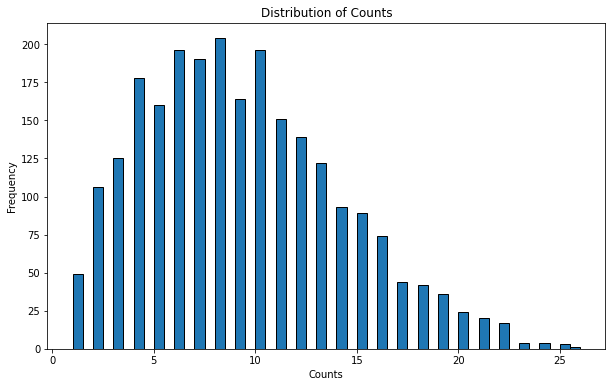

In [22]:
# 기본 통계 요약
print(datewise_counts_non_empty.describe())

# 히스토그램
plt.figure(figsize=(10, 6))
datewise_counts_non_empty.hist(bins=50, edgecolor='black')
plt.title("Distribution of Counts")
plt.xlabel("Counts")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [26]:
data = filtered_df_final
data

,date,time,title,content,press,link,UTC-time,UTC-date
0,2017-01-01,2017-01-01 07:00:00,한국 금융산업 위기… ‘우버 모멘트’ 를 넘어라,\n\n\n\n\n© News1저금리·저성장 전통 금융산업 위기4차 산업혁명...세...,뉴스1,https://n.news.naver.com/mnews/article/421/000...,2016-12-31 22:00:00,2016-12-31
1,2017-01-01,2017-01-01 07:02:03,"2017년 주식 투자…IT, 인프라 ‘솔깃’ 해외주식도 담아보자",\n\t\t\t[헤럴드경제=김지헌 기자] 올해도 지루한 박스피(박스권에 갇힌 코스피...,헤럴드경제,https://n.news.naver.com/mnews/article/016/000...,2016-12-31 22:02:03,2016-12-31
2,2017-01-01,2017-01-01 15:15:04,"英 파운드, 2016년 최악의 통화 ···'디지털통화' 비트코인 최고의 수익자산...",\n【뉴욕=정지원 특파원】 영국의 파운드가 2106년 최악의 통화로 기록됐다.\n ...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,2017-01-01 06:15:04,2017-01-01
3,2017-01-01,2017-01-01 16:03:04,"[신년기획]블록체인, 금융권 넘어 IT기업도 관심",\n\t\t\t“블록체인은 인터넷 이후 나온 가장 혁신적이며 파괴적인 기술이다.”블...,39면 1단,https://n.news.naver.com/mnews/article/030/000...,2017-01-01 07:03:04,2017-01-01
4,2017-01-01,2017-01-01 12:03:13,[2017 국제 핫이슈]블록체인 기술 확산,\n\t\t\t블록체인은 `제2의 인터넷` `넥스트 인터넷`으로 불린다. 새해에는 ...,전자신문,https://n.news.naver.com/mnews/article/030/000...,2017-01-01 03:03:13,2017-01-01
...,...,...,...,...,...,...,...,...
161562,2023-08-30,2023-08-30 10:31:36,올해 상반기 금융사 '의심 거래' 보고 10% 늘어,\n\t\t\t올해 상반기 금융사들의 의심 거래 보고 건수가 지난해보다 10% 가까...,YTN,https://n.news.naver.com/mnews/article/052/000...,2023-08-30 01:31:36,2023-08-30
161563,2023-08-30,2023-08-30 09:12:12,훨훨 난 비트코인…현물 ETF 상장 호재에 6% 급등,"\n비트코인, 박스권 깨고 3700만원 돌파\n\n\n\n[서울=뉴시스]이지영 기자...",뉴시스언론사 선정,https://n.news.naver.com/mnews/article/003/001...,2023-08-30 00:12:12,2023-08-30
161564,2023-08-30,2023-08-30 09:41:23,"이원욱 ""이재명 1년, 미래도 유능함도 없는 민주당 돼""","\n이원욱 ""민주, 여전히 이재명의 대표리스크""""정치 훌리건의 공격 난무하는 친명 ...",뉴시스언론사 선정,https://n.news.naver.com/mnews/article/003/001...,2023-08-30 00:41:23,2023-08-30
161565,2023-08-30,2023-08-30 10:18:01,"업비트, “FDS로 250억 규모 보이스피싱 차단…이상거래 철통방어”",\n\n\n\n\n사진=업비트업비트가 자체 이상거래 탐지시스템(FDS)으로 사전 차...,14면 3단,https://n.news.naver.com/mnews/article/030/000...,2023-08-30 01:18:01,2023-08-30


In [15]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

# Load data
data = pd.read_csv('test.csv')

# Load BERT model and tokenizer
model_name = 'bert-base-uncased'
model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)
model.eval()

# Embed each article content using BERT
embeddings = []
for content in data['content'].tolist():
    tokens = tokenizer(content, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
    with torch.no_grad():
        out = model(**tokens)
    embeddings.append(out['pooler_output'].squeeze().numpy())

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings)

# Cluster articles based on similarity
clusters = []
visited = np.zeros(len(data), dtype=bool)
for i in range(len(data)):
    if not visited[i]:
        similar_articles = np.where(similarity_matrix[i] > 0.6)[0]
        clusters.append(similar_articles)
        visited[similar_articles] = True

# Get representative articles from each cluster
representative_indices = [cluster[0] for cluster in clusters if len(cluster) > 0]

# Create a dataframe with only representative articles
filtered_data = data.iloc[representative_indices].reset_index(drop=True)
filtered_data


c:\Users\user\anaconda3\lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


,date,time,title,content,press,link,year
0,2018-06-10,2018-06-10 20:32:13,"벤처스퀘어 ""블록체인과 스타트업 주제 컨퍼런스 14일 개최""",\r\n\t\t\t서울창업허브에서 10회 'GSC' 행사...비트코인 전도사 로저버...,지디넷코리아,https://n.news.naver.com/mnews/article/092/000...,2018
